## Feature Engineering to Identify Important Variables
* Sangwon Baek
* March 10th, 2023

In [1]:
import pandas as pd
import numpy as np
import re
import random as rn
import statistics 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kstest, norm, mannwhitneyu, chi2_contingency, fisher_exact, ttest_ind, zscore

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score, ParameterGrid, StratifiedKFold, KFold
from sklearn.metrics import average_precision_score, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, auc
from sklearn import metrics
from statsmodels.stats import contingency_tables
import statsmodels.api as sm

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow.keras.backend as K
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib.ticker import FuncFormatter


In [2]:
#Read csv file using pandas
df2 = pd.read_csv('../Data/Preprocessed/CRF_Initial.csv', low_memory=False)
df2 = df2.drop(columns='Unnamed: 0')

na_cols = ['UD_HT','UD_DM','UD_CVD','UD_cancer','UD_other','SMT_fever','SMT_cough','SMT_sputum','SMT_dyspnea',
          'SMT_myalgia', 'SMT_sorethroat', 'SMT_mental', 'SMT_GI', 'steroid']
df2[na_cols] = df2[na_cols].fillna(value=0)

#Remove D-Dimer from the dataframe
ColumnNames = ['No', 'ID', 'age', 'sex', 'dx_date', 'hospitalized_date', 'UD_HT', 'UD_DM', 'UD_CVD', 'UD_cancer',
              'UD_other', 'SMT_fever', 'SMT_cough', 'SMT_sputum', 'SMT_dyspnea', 'SMT_myalgia',
              'SMT_sorethroat', 'SMT_mental', 'SMT_GI', 'TX_0', 'TX_1', 'TX_2', 'TX_3', 'TX_4', 
               'Smoking_0', 'Smoking_1', 'Smoking_2', 'Smoking_3', 'BT', 'SBP', 
               'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH', 
               'DD', 'PCR', 'steroid', 'Mild','Moderate','Severe']
df2 = df2[ColumnNames].drop(columns = 'DD')
# Replace 'UD_' and 'SMT_' in the column names
new_column_names = {col: col.replace('UD_', '').replace('SMT_', '') for col in df2.columns}
# Rename the columns in the dataframe
df2 = df2.rename(columns=new_column_names)

#Separate DF into validation and developmentsets
DevelopmentSet = df2.loc[~df2['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]
ValidationSet = df2.loc[df2['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU'])]

### Data Conversion / Normalization / Train Test Split

In [3]:
def data_preprocessor(train_dataset, test_dataset, columnList, outcome):
    #Create train and test set
    X_train = train_dataset[columnList].values
    X_test = test_dataset[columnList].values
    Y_train = train_dataset[outcome].values.ravel()
    Y_test = test_dataset[outcome].values.ravel()
    
    #Apply StandardScaler Normalization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
        
    return X_train, X_test, Y_train, Y_test

In [4]:
def Compute_CI(values):
    sample_mean = np.mean(values)
    # ddof=1 to compute sample standard deviation
    sample_std = np.std(values, ddof=1) 
    
    # for a 95% confidence interval
    z_value = norm.ppf(0.975)  
    ci_lower = sample_mean - z_value * (sample_std / np.sqrt(len(values)))
    ci_upper = sample_mean + z_value * (sample_std / np.sqrt(len(values)))
    return [ci_lower, ci_upper]

In [5]:
def Result_Table_Builder(modelName, ValidationType, num):
    # Stack the results of ML and DL
    total_results = np.vstack(list(globals()[f"{modelName}_{ValidationType}_Results_{i}"] for i in range(num)))
    
    #Create header column list
    header_list = ['ROC-AUC', 'PR-AUC']
    
    #Create index list
    index_list = [f'Variables #{i}' for i in range(num)]
    index_list[0] = 'ALL_Variables'
    
    #Create result table dataframe
    result_table = pd.DataFrame(data=total_results, columns=header_list, index=index_list)
    
    #Save the result table as CSV file
    result_table.to_csv(f'../Result/{modelName}_{ValidationType}_ResultTable.csv')
    
    return result_table

In [6]:
#List of Columns 
outcome = ['Severe']
#ALL Variables
Variables_0 = ['age', 'sex', 'HT', 'DM', 'CVD', 'cancer', 'other',
               'fever', 'cough', 'sputum', 'dyspnea', 'myalgia', 'sorethroat', 'mental', 'GI', 
               'BT', 'SBP', 'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH']

#Select the variables that commonly appear among 6 selection techniques based on selection probability.
#Available Selection Probabilities exceeding 50%  
#{1}_{2}_{3}_V{4} : 1=Selection Probability, 2=Top cutoff, 3=Variable Numbers, 4=Version when same (default: 1)

#5
Variables_1 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR']
Variables_2 = ['CRP', 'LDH', 'ALC', 'ANC', 'dyspnea']

#6
Variables_3 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea']
Variables_4 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'WBC']
Variables_5 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'PLT']

#7 
Variables_6 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC']
Variables_7 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'PLT']
Variables_8 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'SPO2']

#8
Variables_9 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age']
Variables_10 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2']
Variables_11 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'DBP']

#9
Variables_12 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2']
Variables_13 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'DBP']
Variables_14 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PR']
Variables_15 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'BT']

#10
Variables_16 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP']
Variables_17 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PR']
Variables_18 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT']
Variables_19 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP']
Variables_20 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DM']
Variables_21 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT']
Variables_22 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP']

#11
Variables_23 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PR']
Variables_24 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'BT']
Variables_25 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP']
Variables_26 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'DM']
Variables_27 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT']
Variables_28 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'BT']
Variables_29 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'SBP']
Variables_30 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'DM']
Variables_31 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'PR', 'PLT']
Variables_32 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'DBP']
Variables_33 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'PR']
Variables_34 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'SBP']
Variables_35 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'DM']
Variables_36 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'PLT', 'BT', 'SPO2']
Variables_37 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'PR']
Variables_38 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'BT']
Variables_39 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'SBP']
Variables_40 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'DM']
Variables_41 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'DBP']
Variables_42 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP', 'PR']
Variables_43 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP', 'DM']
Variables_44 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'SBP', 'PLT']
Variables_45 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT', 'PR']
Variables_46 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT', 'DM']
Variables_47 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'BT', 'SBP']
Variables_48 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DM', 'PR']
Variables_49 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'DBP', 'SBP', 'PR']
Variables_50 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'DBP', 'SBP', 'DM']

#12
Variables_51 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'BT']
Variables_52 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'SBP']
Variables_53 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'DM']
Variables_54 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'PLT', 'PR']
Variables_55 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP', 'BT']
Variables_56 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP', 'DM']
Variables_57 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'DBP', 'SBP', 'PR']
Variables_58 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'SBP', 'PR', 'BT']
Variables_59 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'SPO2', 'DBP', 'SBP', 'PR', 'PLT']

#13
Variables_60 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'SBP','DM', 'BT']

Num_Variables = 60

In [7]:
#Preprocess dataset based on columnList
for i in range (Num_Variables):
    exec(f"X{i}_train, X{i}_test, Y{i}_train, Y{i}_test = data_preprocessor(DevelopmentSet, ValidationSet, Variables_{i}, outcome)")

### DNN Model Training Through 5-fold Stratified Cross Validation and Internal Validation

In [8]:
#Hyperparameters and spaces for putting results
def Model_Train_DNN(X, Y):
    #Define empty outer lists to store result values
    auc_outer_list, PRauc_outer_list = [], []    
    N = 5
    
    #Run Cross-Validation for 5 times 
    for i in range (N):
        #Define random_state, Stratified K-Fold
        random_state = 0 
        skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
        
        #Define empty inner lists to store result values
        fpr_list, tpr_list, threshold_list = [], [], []
        precision_list, recall_list, PRthreshold_list = [], [], []
        auc_inner_list, PRauc_inner_list = [], []
        
        #Define earlyStopping, lr_scheduler
        earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1)  
            
        for train, val in skfold.split(X, Y):
            #Split Development dataset into Train/Test 
            X_train = X[train]
            Y_train = Y[train]
            X_val = X[val]
            Y_val = Y[val]

            #Reset Tensorflow
            np.random.seed(random_state)
            rn.seed(random_state)
            tf.random.set_seed(random_state)
            tf.compat.v1.set_random_seed(random_state)
            tf.keras.initializers.Zeros()

            #DNN Final Model Building with 8:2 validation datset 
            model = Sequential([
                keras.layers.Dense(128, input_shape = (X.shape[1],), activation = "relu"),
                keras.layers.BatchNormalization(),
                keras.layers.Dropout(0.3),
                keras.layers.Dense(32, activation = "relu"),
                keras.layers.BatchNormalization(),
                keras.layers.Dropout(0.3),
                keras.layers.Dense(16, activation = "relu"),
                keras.layers.BatchNormalization(),
                keras.layers.Dropout(0.3),
                keras.layers.Dense(1, activation = "sigmoid")
            ])
            model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-2), metrics = ["accuracy"])

            #Use X_train, Y_train for model training | X_val, Y_val for model evaluation during development process
            model.fit(X_train, Y_train, validation_data = (X_val, Y_val), verbose = 0, epochs=50, batch_size=32, 
                      callbacks = [lr_scheduler, earlyStopping])
            
            #Predict model using X_test
            Y_preds = model.predict(X_val)

            #Calculate fpr, tpr, threshold, auc
            fpr, tpr, thresholds = roc_curve(Y_val, Y_preds)
            auc = metrics.auc(fpr, tpr)
            
            #Calculate precision, recall, threshold_pr, pr_auc
            precision, recall, thresholds_pr = precision_recall_curve(Y_val, Y_preds)
            PRauc = metrics.auc(recall, precision)
            
            #Append auc and PRauc to the inner lists
            auc_inner_list.append(auc)
            PRauc_inner_list.append(PRauc)

        #Take the mean of AUC&prAUC from the inner list to get the outer list
        auc_CV = statistics.mean(auc_inner_list)
        auc_outer_list.append(auc_CV)
        PRauc_CV =statistics.mean(PRauc_inner_list)
        PRauc_outer_list.append(PRauc_CV)
    
    #Used for Internal Validation of the model 
    auc_sorted = sorted(auc_outer_list)
    PRauc_sorted = sorted(PRauc_outer_list)
    AUC = np.mean(auc_sorted)
    prAUC = np.mean(PRauc_sorted)
    
    #Compute Confidence Interval 
    AUC_CI_Values = Compute_CI(auc_sorted)
    prAUC_CI_Values = Compute_CI(PRauc_sorted)
    AUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(AUC, AUC_CI_Values[0], AUC_CI_Values[1])
    prAUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(prAUC, prAUC_CI_Values[0], prAUC_CI_Values[1])
    
    return [AUC_CI, prAUC_CI], [AUC, prAUC], [auc_outer_list, PRauc_outer_list]

In [9]:
def Model_Train_IV_ML(X, Y, model):
    #Define empty outer lists to store result values
    auc_outer_list, PRauc_outer_list = [], []    

    for i in range (5):
        #Define random_state, Stratified K-Fold
        random_state = i
        skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    
        #Define empty lists to store result values
        fpr_list, tpr_list, threshold_list = [], [], []
        precision_list, recall_list, PRthreshold_list = [], [], []
        auc_inner_list, PRauc_inner_list = [], []
        
        for train, val in skfold.split(X, Y):
            #Split Development dataset into Train/Test 
            X_train = X[train]
            Y_train = Y[train]
            X_val = X[val]
            Y_val = Y[val]
            
            #Fit the model with trainset
            model = model.fit(X_train, Y_train)
            
            #Predict model using X_val
            Y_preds = model.predict_proba(X_val)[:,1]
            
            #Calculate fpr, tpr, threshold, auc
            fpr, tpr, thresholds = roc_curve(Y_val, Y_preds)
            auc = metrics.auc(fpr, tpr)
            
            #Calculate precision, recall, threshold_pr, pr_auc
            precision, recall, thresholds_pr = precision_recall_curve(Y_val, Y_preds)
            PRauc = metrics.auc(recall, precision)
            
            #Append auc and PRauc to the inner lists
            auc_inner_list.append(auc)
            PRauc_inner_list.append(PRauc)
        
        #Take the mean of AUC&prAUC from the inner list to get the outer list
        auc_CV = statistics.mean(auc_inner_list)
        auc_outer_list.append(auc_CV)
        PRauc_CV =statistics.mean(PRauc_inner_list)
        PRauc_outer_list.append(PRauc_CV)

    #Used for Internal Validation of the model 
    auc_sorted = sorted(auc_outer_list)
    PRauc_sorted = sorted(PRauc_outer_list)
    AUC = np.mean(auc_sorted)
    prAUC = np.mean(PRauc_sorted)
     
    #Compute Confidence Interval 
    AUC_CI_Values = Compute_CI(auc_sorted)
    prAUC_CI_Values = Compute_CI(PRauc_sorted)
    AUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(AUC, AUC_CI_Values[0], AUC_CI_Values[1])
    prAUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(prAUC, prAUC_CI_Values[0], prAUC_CI_Values[1])

    return [AUC_CI, prAUC_CI], [AUC, prAUC], [auc_outer_list, PRauc_outer_list]

### ML Models Training through 5-Fold Stratified CV and Internal Validation

In [10]:
#Hyper-parameter tuned ML Models obtained through GridSearchCV with ALL variables & Whole Development set. *See Pipeline 3

# RF parameter:  (criterion='entropy', max_depth=25, max_features='sqrt', min_samples_split=5, n_estimators = 299, n_jobs=-1)
RF_model = RandomForestClassifier(criterion='entropy', max_depth=25, max_features='sqrt', min_samples_split=5, n_estimators = 299, n_jobs=-1)

# MLR parameter:  (C=0.06, max_iter=245, penalty='l2', solver='liblinear')
MLR_model = LogisticRegression(C=0.06, max_iter=245, penalty='l2', solver='liblinear')
    
# XGB parameter:  {'colsample_bytree': 0.4, 'eta': 0.2, 'gamma': 0.75, 'learning_rate': 0.45, 'max_depth': 18, 'min_child_weight': 14, 'nthread': 6}
XGB_model = XGBClassifier(colsample_bytree=0.4, eta=0.2, gamma=0.75, learning_rate=0.45, max_depth=18, min_child_weight=14, nthread=6)

# GBM parameter:  {'learning_rate': 0.15, 'max_depth': 10, 'n_estimators': 91}
GBM_model = GradientBoostingClassifier(learning_rate=0.15, max_depth=10, n_estimators=91)

# SVM parameter:  {'C': 0.8, 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}
SVM_model = SVC(C=0.8, gamma='auto', kernel='rbf', probability=True)

In [11]:
#ML Training and Internal Validation 
for i in range(Num_Variables):
    #DNN Internal Validation
    exec(f"DNN_IV_Results_{i}, DNN_IV_AUC_prAUC_{i}, DNN_IV_Outer_List_{i} = Model_Train_DNN(X{i}_train, Y{i}_train)")
    
    #XGB Internal Validation Results
    exec(f"XGB_IV_Results_{i}, XGB_IV_AUC_prAUC_{i}, XGB_IV_Outer_List_{i}  = Model_Train_IV_ML(X{i}_train, Y{i}_train, XGB_model)")

    #GBM External Validation Results
    exec(f"GBM_IV_Results_{i}, GBM_IV_AUC_prAUC_{i}, GBM_IV_Outer_List_{i}  = Model_Train_IV_ML(X{i}_train, Y{i}_train, GBM_model)")
    
    #MLR External Validation Results
    exec(f"MLR_IV_Results_{i}, MLR_IV_AUC_prAUC_{i}, MLR_IV_Outer_List_{i}  = Model_Train_IV_ML(X{i}_train, Y{i}_train, MLR_model)")

    #RF External Validation Results
    exec(f"RF_IV_Results_{i}, RF_IV_AUC_prAUC_{i}, RF_IV_Outer_List_{i}  = Model_Train_IV_ML(X{i}_train, Y{i}_train, RF_model)")

    #SVM External Validation Results
    exec(f"SVM_IV_Results_{i}, SVM_IV_AUC_prAUC_{i}, SVM_IV_Outer_List_{i}  = Model_Train_IV_ML(X{i}_train, Y{i}_train, SVM_model)")


Epoch 11: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 9: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 18: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 7: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 10: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 8: early stopping
28/28 [==============================] - 0s 519us/step
Epoch 9: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 11: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 13: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 14: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 11: early stopping
28/28 [==============================] - 0s 519us/step
Epoch 7: early stopping
28/28 [==============================] - 0s 482us/step
Epoch 10: early stopping
28/28 [=============

In [12]:
#Internal Validation Result Table Building for DNN model
Result_Table_Builder("DNN", "IV", Num_Variables)

,ROC-AUC,PR-AUC
ALL_Variables,0.885 [0.884-0.886],0.608 [0.607-0.609]
Variables #1,0.877 [0.876-0.878],0.582 [0.577-0.587]
Variables #2,0.876 [0.874-0.877],0.588 [0.586-0.589]
Variables #3,0.880 [0.879-0.881],0.595 [0.590-0.600]
Variables #4,0.878 [0.877-0.879],0.583 [0.579-0.586]
Variables #5,0.882 [0.880-0.885],0.587 [0.584-0.590]
Variables #6,0.879 [0.878-0.881],0.592 [0.589-0.596]
Variables #7,0.885 [0.883-0.887],0.600 [0.596-0.604]
Variables #8,0.881 [0.879-0.883],0.597 [0.594-0.599]
Variables #9,0.891 [0.890-0.891],0.613 [0.609-0.616]


In [13]:
#Internal Validation Result Table Building for RF model
Result_Table_Builder("RF", "IV", Num_Variables)

,ROC-AUC,PR-AUC
ALL_Variables,0.901 [0.900-0.903],0.652 [0.647-0.656]
Variables #1,0.873 [0.872-0.874],0.588 [0.583-0.592]
Variables #2,0.865 [0.862-0.868],0.570 [0.565-0.576]
Variables #3,0.875 [0.874-0.876],0.588 [0.585-0.592]
Variables #4,0.872 [0.871-0.873],0.586 [0.583-0.589]
Variables #5,0.882 [0.881-0.883],0.605 [0.599-0.611]
Variables #6,0.875 [0.873-0.877],0.591 [0.588-0.593]
Variables #7,0.884 [0.882-0.885],0.604 [0.598-0.610]
Variables #8,0.878 [0.877-0.879],0.595 [0.592-0.598]
Variables #9,0.887 [0.885-0.888],0.610 [0.606-0.614]


In [14]:
#Internal Validation Result Table Building for MLR model
Result_Table_Builder("MLR", "IV", Num_Variables)

,ROC-AUC,PR-AUC
ALL_Variables,0.891 [0.890-0.892],0.619 [0.617-0.622]
Variables #1,0.861 [0.861-0.862],0.567 [0.565-0.569]
Variables #2,0.863 [0.862-0.863],0.570 [0.568-0.571]
Variables #3,0.867 [0.866-0.867],0.580 [0.579-0.581]
Variables #4,0.861 [0.860-0.862],0.567 [0.565-0.568]
Variables #5,0.867 [0.867-0.868],0.576 [0.573-0.578]
Variables #6,0.866 [0.866-0.867],0.580 [0.578-0.581]
Variables #7,0.873 [0.872-0.873],0.589 [0.587-0.591]
Variables #8,0.867 [0.867-0.868],0.583 [0.582-0.584]
Variables #9,0.881 [0.881-0.882],0.603 [0.601-0.604]


In [15]:
#Internal Validation Result Table Building for XGB model
Result_Table_Builder("XGB", "IV", Num_Variables)

,ROC-AUC,PR-AUC
ALL_Variables,0.881 [0.879-0.884],0.591 [0.582-0.601]
Variables #1,0.852 [0.850-0.854],0.535 [0.528-0.541]
Variables #2,0.852 [0.848-0.855],0.520 [0.516-0.525]
Variables #3,0.855 [0.853-0.856],0.539 [0.534-0.545]
Variables #4,0.848 [0.845-0.851],0.535 [0.526-0.545]
Variables #5,0.858 [0.856-0.860],0.553 [0.546-0.561]
Variables #6,0.853 [0.850-0.855],0.540 [0.533-0.547]
Variables #7,0.861 [0.859-0.864],0.561 [0.556-0.565]
Variables #8,0.858 [0.854-0.861],0.548 [0.543-0.552]
Variables #9,0.868 [0.866-0.870],0.553 [0.546-0.560]


In [16]:
#Internal Validation Result Table Building for GBM model
Result_Table_Builder("GBM", "IV", Num_Variables)

,ROC-AUC,PR-AUC
ALL_Variables,0.890 [0.887-0.893],0.617 [0.615-0.619]
Variables #1,0.856 [0.853-0.859],0.548 [0.537-0.559]
Variables #2,0.849 [0.848-0.851],0.541 [0.533-0.549]
Variables #3,0.856 [0.853-0.859],0.555 [0.550-0.561]
Variables #4,0.857 [0.855-0.859],0.551 [0.546-0.556]
Variables #5,0.863 [0.860-0.865],0.564 [0.557-0.571]
Variables #6,0.858 [0.854-0.861],0.555 [0.551-0.559]
Variables #7,0.865 [0.862-0.868],0.568 [0.562-0.573]
Variables #8,0.860 [0.858-0.862],0.564 [0.557-0.571]
Variables #9,0.869 [0.867-0.870],0.569 [0.567-0.572]


In [17]:
#Internal Validation Result Table Building for SVM model
Result_Table_Builder("SVM", "IV", Num_Variables)

,ROC-AUC,PR-AUC
ALL_Variables,0.865 [0.863-0.867],0.584 [0.579-0.590]
Variables #1,0.806 [0.803-0.810],0.537 [0.534-0.541]
Variables #2,0.803 [0.799-0.806],0.529 [0.527-0.532]
Variables #3,0.803 [0.801-0.805],0.542 [0.538-0.546]
Variables #4,0.803 [0.800-0.806],0.538 [0.533-0.542]
Variables #5,0.813 [0.810-0.816],0.546 [0.541-0.550]
Variables #6,0.803 [0.801-0.805],0.542 [0.535-0.549]
Variables #7,0.813 [0.811-0.815],0.550 [0.545-0.555]
Variables #8,0.810 [0.808-0.813],0.550 [0.547-0.553]
Variables #9,0.829 [0.825-0.834],0.575 [0.570-0.581]


### DNN and ML Models Train with Whole Development Set -> External Validation

In [18]:
def DNN_Model_Development(X_development, Y_development):
    #Define random_state
    random_state = 0 
    
    #Split the development dataset into train and test set (random_state = constant) 
    X_train, X_val, Y_train, Y_val = train_test_split(X_development, Y_development, test_size=0.2, random_state=random_state, stratify=Y_development)

    #Reset Tensorflow
    np.random.seed(random_state)
    rn.seed(random_state)
    tf.random.set_seed(random_state)
    tf.compat.v1.set_random_seed(random_state)
    tf.keras.initializers.Zeros()
    
    #Define earlyStopping, lr_scheduler
    earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1)

    #DNN Final Model Building with 8:2 validation datset 
    model = Sequential([
        keras.layers.Dense(128, input_shape = (X_development.shape[1],), activation = "relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation = "relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(16, activation = "relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation = "sigmoid")
    ])
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-2), metrics = ["accuracy"])

    #Use X_train, Y_train for model training | X_val, Y_val for model evaluation during development process
    model.fit(X_train, Y_train, validation_data = (X_val, Y_val), verbose = 0, epochs=50, batch_size=32, 
              callbacks = [lr_scheduler, earlyStopping])

    return model

In [19]:
#Full Model Trained with Whole Development Dataset 
for i in range(Num_Variables):
    # DNN parameter: {Layers: 128 -> 32 -> 10 -> 1, Dropout: 0.3, BatchNormalization, EarlyStopper (Patience=5), LR_scheduler (factor=0.7, Patience=2)}
    exec(f"DNN_model_{i} = DNN_Model_Development(X{i}_train, Y{i}_train)")

    # RF parameter: (criterion='entropy', max_depth=25, max_features='sqrt', min_samples_split=5, n_estimators = 299, n_jobs=-1)
    exec(f"RF_model_{i} = RandomForestClassifier(criterion='entropy', max_depth=25, max_features='sqrt', min_samples_split=5, n_estimators = 299, n_jobs=-1).fit(X{i}_train, Y{i}_train)")
    
    # MLR parameter:  {C=0.06, max_iter=245, penalty='l2', solver='liblinear'}
    exec(f"MLR_model_{i} = LogisticRegression(C=0.06, max_iter=245, penalty='l2', solver='liblinear').fit(X{i}_train, Y{i}_train)")

    # XGB parameter:  {'colsample_bytree': 0.4, 'eta': 0.2, 'gamma': 0.75, 'learning_rate': 0.45, 'max_depth': 18, 'min_child_weight': 14, 'nthread': 6}
    exec(f"XGB_model_{i} = XGBClassifier(colsample_bytree=0.4, eta=0.2, gamma=0.75, learning_rate=0.45, max_depth=18, min_child_weight=14, nthread=6).fit(X{i}_train, Y{i}_train)")

    # GBM parameter:  {'learning_rate': 0.15, 'max_depth': 10, 'n_estimators': 91}
    exec(f"GBM_model_{i} = GradientBoostingClassifier(learning_rate=0.15, max_depth=10, n_estimators=91).fit(X{i}_train, Y{i}_train)")

    # SVM parameter:  {'C': 0.8, 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}
    exec(f"SVM_model_{i} = SVC(C=0.8, gamma='auto', kernel='rbf', probability=True).fit(X{i}_train, Y{i}_train)")
    

Epoch 18: early stopping
Epoch 18: early stopping
Epoch 22: early stopping
Epoch 17: early stopping
Epoch 16: early stopping
Epoch 29: early stopping
Epoch 27: early stopping
Epoch 23: early stopping
Epoch 25: early stopping
Epoch 22: early stopping
Epoch 45: early stopping
Epoch 25: early stopping
Epoch 34: early stopping
Epoch 30: early stopping
Epoch 41: early stopping
Epoch 41: early stopping
Epoch 31: early stopping
Epoch 22: early stopping
Epoch 19: early stopping
Epoch 33: early stopping
Epoch 16: early stopping
Epoch 31: early stopping
Epoch 31: early stopping
Epoch 10: early stopping
Epoch 10: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 12: early stopping
Epoch 25: early stopping
Epoch 48: early stopping
Epoch 39: early stopping
Epoch 6: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 22: early stopping
Epoch 18: early stopping
Epoch 9: early stopping
Epoch 9: early stopping
Epoch 22: early stopping
Epoch 9: early stopping
Epoch 10

In [20]:
def External_Validation_CL(X_test, Y_test, model, DeepLearning=False):
    #Define Number of Bootstrapping (100) to conduct 
    N_Bootstraps = 100
    
    #Define empty lists to store result values
    fpr_list, tpr_list, threshold_list = [], [], []
    precision_list, recall_list, PRthreshold_list = [], [], []
    auc_list, PRauc_list = [], []
    
    for i in range (N_Bootstraps):
        #Set a different random seed for bootstrapping indices 
        np.random.seed(i)

        # Generate a bootstrap sample from the development dataset with replacement
        idx = np.random.choice(X_test.shape[0], X_test.shape[0], replace=True)
        X_test_boot = X_test[idx]
        Y_test_boot = Y_test[idx]
        
        if DeepLearning==True: 
            #Get predictions for ML models using X_test_boot
            Y_preds = model.predict(X_test_boot)
        else: 
            #Get predictions for ML models using X_test_boot
            Y_preds = model.predict_proba(X_test_boot)[:,1]

        #Calculate fpr, tpr, threshold, auc
        fpr, tpr, thresholds = roc_curve(Y_test_boot, Y_preds)
        auc = metrics.auc(fpr, tpr)
        
        #Calculate precision, recall, threshold_pr, pr_auc
        precision, recall, thresholds_pr = precision_recall_curve(Y_test_boot, Y_preds)
        PRauc = metrics.auc(recall, precision)
        
        #Append the auc & PRauc to the list
        auc_list.append(auc)
        PRauc_list.append(PRauc)

    #Used for External Validation of the model     
    auc_sorted = sorted(auc_list)
    PRauc_sorted = sorted(PRauc_list)
    AUC = np.mean(auc_sorted)
    prAUC = np.mean(PRauc_sorted)
    
    #Compute Confidence Interval 
    AUC_CI_Values = Compute_CI(auc_sorted)
    prAUC_CI_Values = Compute_CI(PRauc_sorted)
    AUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(AUC, AUC_CI_Values[0], AUC_CI_Values[1])
    prAUC_CI = "{:.3F} [{:.3F}-{:.3F}]".format(prAUC, prAUC_CI_Values[0], prAUC_CI_Values[1])
    
    return [AUC_CI, prAUC_CI], [AUC, prAUC], [auc_list, PRauc_list]    

In [21]:
for i in range(Num_Variables):
    #DNN External Validation Results
    exec(f"DNN_EV_Results_{i}, DNN_EV_AUC_prAUC_{i}, DNN_EV_Outer_List_{i} = External_Validation_CL(X{i}_test, Y{i}_test, DNN_model_{i}, True)")
    
    #XGB External Validation Results
    exec(f"XGB_EV_Results_{i}, XGB_EV_AUC_prAUC_{i}, XGB_EV_Outer_List_{i} = External_Validation_CL(X{i}_test, Y{i}_test, XGB_model_{i})")

    #GBM External Validation Results
    exec(f"GBM_EV_Results_{i}, GBM_EV_AUC_prAUC_{i}, GBM_EV_Outer_List_{i} = External_Validation_CL(X{i}_test, Y{i}_test, GBM_model_{i})")
    
    #MLR External Validation Results
    exec(f"MLR_EV_Results_{i}, MLR_EV_AUC_prAUC_{i}, MLR_EV_Outer_List_{i} = External_Validation_CL(X{i}_test, Y{i}_test, MLR_model_{i})")

    #RF External Validation Results
    exec(f"RF_EV_Results_{i}, RF_EV_AUC_prAUC_{i}, RF_EV_Outer_List_{i} = External_Validation_CL(X{i}_test, Y{i}_test, RF_model_{i})")

    #SVM External Validation Results
    exec(f"SVM_EV_Results_{i}, SVM_EV_AUC_prAUC_{i}, SVM_EV_Outer_List_{i} = External_Validation_CL(X{i}_test, Y{i}_test, SVM_model_{i})")

50/50 [==============================] - 0s 2ms/step


In [22]:
#External Validation Result Table Building for DNN model (Y_preds with X_test_Boot, N_Bootstrap: 100)
Result_Table_Builder("DNN", "EV", Num_Variables)

,ROC-AUC,PR-AUC
ALL_Variables,0.939 [0.937-0.940],0.590 [0.582-0.598]
Variables #1,0.912 [0.910-0.915],0.537 [0.529-0.545]
Variables #2,0.908 [0.905-0.910],0.506 [0.498-0.515]
Variables #3,0.912 [0.909-0.914],0.532 [0.524-0.541]
Variables #4,0.911 [0.908-0.913],0.534 [0.526-0.542]
Variables #5,0.910 [0.907-0.912],0.536 [0.528-0.544]
Variables #6,0.912 [0.909-0.914],0.526 [0.518-0.534]
Variables #7,0.909 [0.906-0.911],0.513 [0.505-0.522]
Variables #8,0.915 [0.912-0.917],0.557 [0.549-0.564]
Variables #9,0.926 [0.924-0.928],0.545 [0.536-0.553]


In [23]:
#External Validation Result Table Building for RF model
Result_Table_Builder("RF", "EV", Num_Variables)

,ROC-AUC,PR-AUC
ALL_Variables,0.929 [0.927-0.931],0.553 [0.545-0.562]
Variables #1,0.897 [0.894-0.900],0.438 [0.429-0.447]
Variables #2,0.888 [0.885-0.891],0.447 [0.437-0.456]
Variables #3,0.900 [0.897-0.902],0.443 [0.433-0.452]
Variables #4,0.899 [0.896-0.901],0.453 [0.444-0.462]
Variables #5,0.898 [0.895-0.901],0.469 [0.460-0.478]
Variables #6,0.904 [0.902-0.907],0.468 [0.459-0.478]
Variables #7,0.906 [0.904-0.909],0.474 [0.465-0.484]
Variables #8,0.911 [0.909-0.913],0.474 [0.465-0.484]
Variables #9,0.916 [0.914-0.918],0.508 [0.499-0.518]


In [24]:
#External Validation Result Table Building for MLR model
Result_Table_Builder("MLR", "EV", Num_Variables)

,ROC-AUC,PR-AUC
ALL_Variables,0.934 [0.932-0.935],0.553 [0.544-0.561]
Variables #1,0.887 [0.884-0.890],0.488 [0.480-0.497]
Variables #2,0.892 [0.890-0.895],0.484 [0.475-0.492]
Variables #3,0.896 [0.894-0.899],0.488 [0.480-0.496]
Variables #4,0.888 [0.885-0.890],0.489 [0.481-0.497]
Variables #5,0.891 [0.888-0.893],0.495 [0.486-0.503]
Variables #6,0.897 [0.895-0.900],0.488 [0.480-0.497]
Variables #7,0.902 [0.900-0.905],0.495 [0.486-0.503]
Variables #8,0.899 [0.897-0.902],0.497 [0.488-0.505]
Variables #9,0.917 [0.915-0.919],0.521 [0.513-0.530]


In [25]:
#External Validation Result Table Building for XGB model
Result_Table_Builder("XGB", "EV", Num_Variables)

,ROC-AUC,PR-AUC
ALL_Variables,0.917 [0.914-0.919],0.498 [0.489-0.507]
Variables #1,0.890 [0.887-0.893],0.445 [0.436-0.454]
Variables #2,0.885 [0.882-0.888],0.426 [0.416-0.435]
Variables #3,0.884 [0.881-0.887],0.429 [0.420-0.438]
Variables #4,0.884 [0.881-0.887],0.461 [0.452-0.470]
Variables #5,0.884 [0.881-0.887],0.449 [0.440-0.459]
Variables #6,0.888 [0.885-0.890],0.433 [0.424-0.442]
Variables #7,0.891 [0.888-0.894],0.446 [0.437-0.456]
Variables #8,0.884 [0.881-0.887],0.474 [0.464-0.483]
Variables #9,0.902 [0.899-0.904],0.475 [0.467-0.484]


In [26]:
#External Validation Result Table Building for GBM model
Result_Table_Builder("GBM", "EV", Num_Variables)

,ROC-AUC,PR-AUC
ALL_Variables,0.915 [0.913-0.918],0.535 [0.526-0.545]
Variables #1,0.878 [0.875-0.881],0.432 [0.422-0.441]
Variables #2,0.881 [0.878-0.884],0.422 [0.411-0.432]
Variables #3,0.866 [0.863-0.869],0.399 [0.390-0.409]
Variables #4,0.883 [0.880-0.886],0.438 [0.428-0.448]
Variables #5,0.882 [0.878-0.885],0.436 [0.427-0.446]
Variables #6,0.880 [0.877-0.883],0.454 [0.444-0.463]
Variables #7,0.887 [0.884-0.890],0.444 [0.434-0.453]
Variables #8,0.887 [0.884-0.889],0.439 [0.429-0.449]
Variables #9,0.898 [0.896-0.901],0.475 [0.464-0.485]


In [27]:
#External Validation Result Table Building for SVM model
Result_Table_Builder("SVM", "EV", Num_Variables)

,ROC-AUC,PR-AUC
ALL_Variables,0.901 [0.898-0.903],0.511 [0.502-0.520]
Variables #1,0.806 [0.801-0.810],0.436 [0.428-0.445]
Variables #2,0.832 [0.828-0.837],0.417 [0.408-0.426]
Variables #3,0.810 [0.805-0.815],0.417 [0.409-0.426]
Variables #4,0.819 [0.814-0.824],0.439 [0.431-0.447]
Variables #5,0.813 [0.808-0.818],0.471 [0.463-0.480]
Variables #6,0.812 [0.808-0.817],0.420 [0.412-0.429]
Variables #7,0.818 [0.813-0.823],0.442 [0.434-0.451]
Variables #8,0.814 [0.809-0.819],0.448 [0.439-0.456]
Variables #9,0.854 [0.849-0.858],0.444 [0.435-0.452]


### Violin Plots for showing AUC and PRAUC values among 7 DL&ML models 

In [28]:
def Create_DF_For_ViolinPlots(model, val_type, list_type, AUC=True, num=None):
    if AUC:
        # Create lists of AUC scores for each model
        auc_scores_dict = {}
        auc_scores = [globals()[f'{model}_{val_type}_{list_type}_{i}'][0] for i in range(num)]
        auc_scores_dict[model] = auc_scores
    
        # Create a dictionary with the AUC scores
        DataFrame = pd.DataFrame(auc_scores_dict)

        # IF list is the outer list explod it so that all gets included
        if list_type == 'Outer_List':
            DataFrame = DataFrame.explode(model)

        #Rename the columns
        DataFrame.columns = [f'{model}']
    return DataFrame

In [29]:
model_list = ['MLR', 'DNN', 'RF', 'XGB',  'GBM', 'SVM']
IV_AUC_dfs, IV_AUC_Outer_List_dfs, IV_PRAUC_dfs, IV_PRAUC_Outer_List_dfs = [], [], [], []
#Create AUC scores df for violin plots
for model in model_list:
    IV_AUC_DF = Create_DF_For_ViolinPlots(model, 'IV', 'AUC_prAUC', True, Num_Variables)
    IV_AUC_Outer_List_DF = Create_DF_For_ViolinPlots(model, 'IV', 'Outer_List', True, Num_Variables)
    exec(f"IV_{model}_AUC_DF = IV_AUC_DF")
    exec(f"IV_{model}_AUC_Outer_List_DF = IV_AUC_Outer_List_DF")
    IV_AUC_dfs.append(eval(f"IV_{model}_AUC_DF"))
    IV_AUC_Outer_List_dfs.append(eval(f"IV_{model}_AUC_Outer_List_DF"))

combined_IV_AUC_DF = pd.concat(IV_AUC_dfs, axis=1)
combined_IV_AUC_Outer_List_DF = pd.concat(IV_AUC_Outer_List_dfs, axis=1).astype(float)

In [30]:
model_list = ['MLR', 'DNN', 'RF', 'XGB',  'GBM', 'SVM']
EV_AUC_dfs, EV_AUC_Outer_List_dfs, EV_PRAUC_dfs, EV_PRAUC_Outer_List_dfs = [], [], [], []
#Create AUC scores df for violin plots
for model in model_list:
    EV_AUC_DF = Create_DF_For_ViolinPlots(model, 'EV', 'AUC_prAUC', True, Num_Variables)
    EV_AUC_Outer_List_DF = Create_DF_For_ViolinPlots(model, 'EV', 'Outer_List', True, Num_Variables)
    exec(f"EV_{model}_AUC_DF = EV_AUC_DF")
    exec(f"EV_{model}_AUC_Outer_List_DF = EV_AUC_Outer_List_DF")
    EV_AUC_dfs.append(eval(f"EV_{model}_AUC_DF"))
    EV_AUC_Outer_List_dfs.append(eval(f"EV_{model}_AUC_Outer_List_DF"))

combined_EV_AUC_DF = pd.concat(EV_AUC_dfs, axis=1)
combined_EV_AUC_Outer_List_DF = pd.concat(EV_AUC_Outer_List_dfs, axis=1).astype(float)

In [34]:
#Save each dataframe for future usage 
combined_IV_AUC_DF.to_csv('../Result/combined_IV_AUC_DF.csv', index=False)
combined_EV_AUC_DF.to_csv('../Result/combined_EV_AUC_DF.csv', index=False)
combined_IV_AUC_Outer_List_DF.to_csv('../Result/combined_IV_AUC_Outer_List_DF.csv', index=False)
combined_EV_AUC_Outer_List_DF.to_csv('../Result/combined_EV_AUC_Outer_List_DF.csv', index=False)


In [ ]:
# #Read the csv file 
# combined_IV_AUC_DF = pd.read_csv('../Result/combined_IV_AUC_DF.csv')
# combined_EV_AUC_DF = pd.read_csv('../Result/combined_EV_AUC_DF.csv')
# combined_IV_AUC_Outer_List_DF = pd.read_csv('../Result/combined_IV_AUC_Outer_List_DF.csv')
# combined_EV_AUC_Outer_List_DF = pd.read_csv('../Result/combined_EV_AUC_Outer_List_DF.csv')


In [56]:
# Define the formatter function
def format_tick(x, pos):
    return f"{x:.1f}".replace('.', '·')

def Violin_Plot(IV_Dataframe, EV_Dataframe, AUC=True):

    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    
    # Instantiate dataframe
    IV_DF = IV_Dataframe
    EV_DF = EV_Dataframe

    # Combine Internal Validation and External Validation DataFrames
    IV_DF['type'] = 'IV'
    EV_DF['type'] = 'EV'
    combined_DF = pd.concat([IV_DF, EV_DF])
    length_IV = len(IV_DF)
    length_EV = len(EV_DF)
    y_range = (0.7, 1.01)
    
    if AUC:
        y_label = 'AUROC'
    else:
        y_label = 'PRAUC'

    # Melt the combined DataFrame
    melted_DF = pd.melt(combined_DF, id_vars=['type'], var_name='Model', value_name=y_label)

    # Plot Violin plots for 100 IV and EV AUC scores 
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    # Plot the violin plot
    sns.violinplot(x='Model', y=y_label, hue='type', data=melted_DF, ax=ax)

    # Extract the first value of each column
    first_values_IV = IV_DF.iloc[0, :-1]
    first_values_EV = EV_DF.iloc[0, :-1]

    # Calculate the x_positions for the scatter points
    model_count = len(IV_DF.columns[:-1])
    x_positions_IV = np.arange(model_count) - 0.2
    x_positions_EV = np.arange(model_count) + 0.2

    # Plot the scatter points for IV and EV
    ax.scatter(x_positions_IV, first_values_IV, marker='D', s=50, color='darkred')
    ax.scatter(x_positions_EV, first_values_EV, marker='D', s=50, color='blue')

    # Adjust the x-axis tick labels
    ax.set_xticklabels(IV_DF.columns[:-1], ha='center')
    
    # Set the y-axis label and limits
    ax.set_ylabel(y_label)
    ax.set_ylim(*y_range)
    
    # Set the formatter functions for the x and y axes of the inset plot
    ax.yaxis.set_major_formatter(FuncFormatter(format_tick))

    # Modify the ticks for the outer box
    ax.set_yticks([0.7, 0.8, 0.9, 1.0])
    # ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

    # Customize legend to only include IV and EV labels
    # handles, labels = ax.get_legend_handles_labels()
    ax.legend(loc='lower right', title='', fontsize=10)
    
    # plt.title(f'Violin plots for {length_IV} IV and {length_EV} EV {y_label}', fontsize=15)
    plt.savefig(f'../Result/S_Figure2_{y_label}_{length_EV}_ViolinPlots_0.7.png', dpi=600)

    # Show the plot
    plt.show()

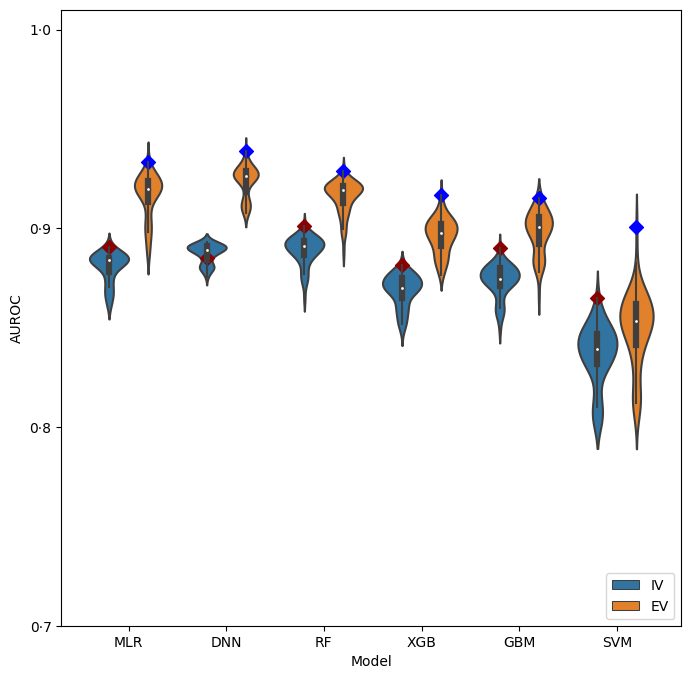

In [57]:
Violin_Plot(combined_IV_AUC_DF, combined_EV_AUC_DF, True)

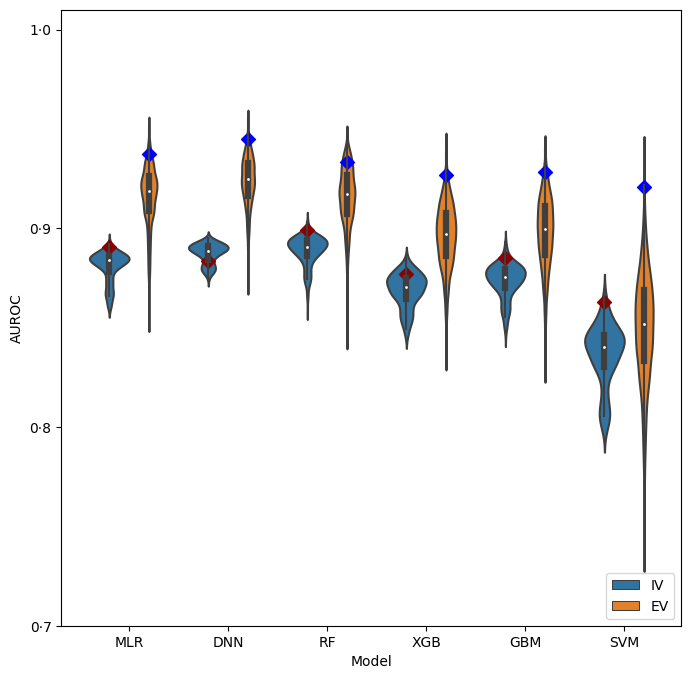

In [51]:
Violin_Plot(combined_IV_AUC_Outer_List_DF, combined_EV_AUC_Outer_List_DF, True)